In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm 
import random 

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader


#%cd "/content/drive/My Drive/ml-project-2-marmlla_2/"
import Helper.Preprocessing as pp 
import Helper.Model as ml 
import Helper.Display as ds
import Helper.Pipeline as pl

### load data

In [134]:
df = pd.read_csv("Data/data_daily/dataset_daily.csv")
df.head(2)

Date  Open_USD_CHF  Open_CHF_EUR  Open_CHF_GBP  Open_CHF_JPY  \
0  2001-12-27        1.6886        0.6723        0.4071         77.46   
1  2001-12-28        1.6776        0.6745        0.4106         78.48   

   Open_CHF_CAD  Open_BondCH1m  Open_BondCH2y  Open_BondCH10y  Open_SMI  \
0        0.9477           1.68          2.011           3.460    6392.1   
1        0.9520           1.68          2.059           3.474    6430.6   

   Open_USD_JPY  Open_USD_EUR  Open_USD_GBP  Open_USD_CAD  Open_BondUS1m  \
0        130.82        1.1356        0.6876        1.6010          1.751   
1        131.68        1.1319        0.6887        1.5981          1.720   

   Open_BondUS2y  Open_BondUS10y  Open_SP500  
0          3.307           5.072      1149.4  
1          3.169           5.113      1157.1

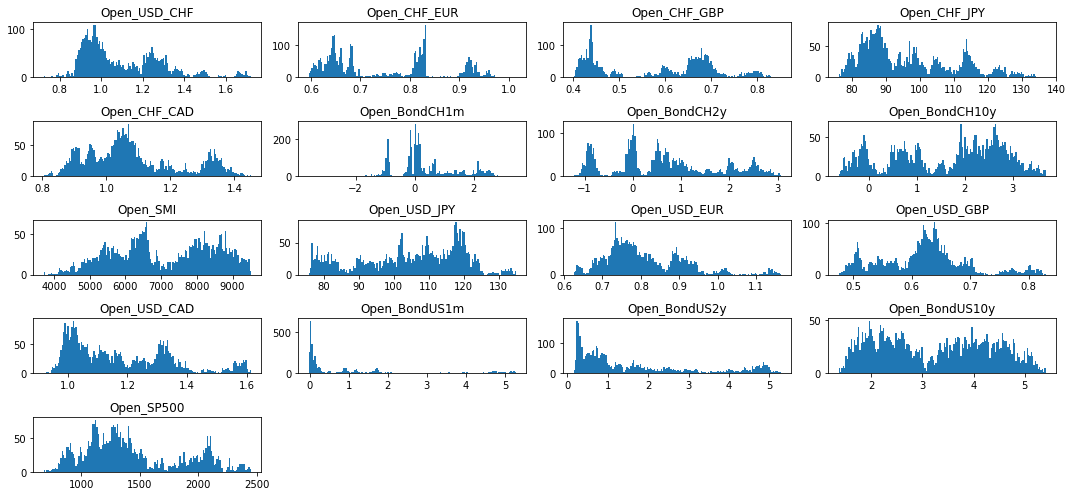

In [266]:
data = []
for i in df.columns[1:]:
    data.append(df[i])

fig = plt.figure(figsize=(15, 7))

name  = df.columns[1:]

for i in range(len(data)):   
    plt.subplot(5, 4,1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

205
67
41
Shape:             
X train     (2710, 4, 17), y train     (2710, 17)            
X train val (302, 4, 17) , y train val (302, 17)             
X test      (532, 4, 17) , y test      (532, 17)


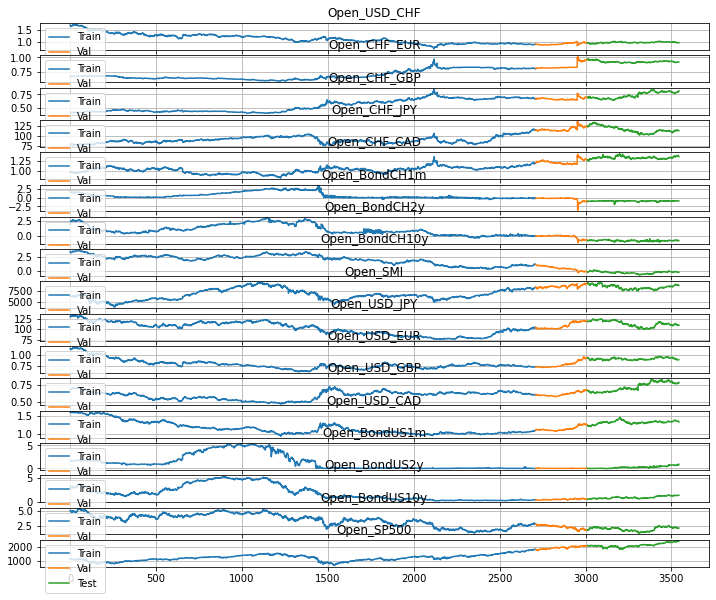

In [326]:
device = 'cpu'
LOOKBACK = 4
NORM = True
train_x, val_x, test_x, train_y, val_y, test_y, norm, _ = pp.generate_dataset(
  data,
  lookback_=LOOKBACK,
  norm_=NORM,
  trend_ = True, 
  fraction_val_=0.1,
  fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [327]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y[np.isnan(train_y)] = 0.5
val_y[np.isnan(val_y)] = 0.5
test_y[np.isnan(test_y)] = 0.5

In [328]:
def add_label_data(df_x, df_y):
    X_  = np.zeros((df_x.shape[0], df_x.shape[1],df_x.shape[2]*2))
    c= 0
    for i in range(df_x.shape[2]*2):

        if(i%2 == 0):
            X_[:, :, i] = df_x[:,:,c]
        else:
            for j in range(df_x.shape[1],  len(X_)):
                X_[j, :, i] = np.concatenate((df_y[j-(df_x.shape[1]-1):j,c], [0.5]))
            c+= 1

    return X_[df_x.shape[1]:]

train_x_fin  = add_label_data(train_x, train_y)
val_x_fin  = add_label_data(val_x, val_y)
test_x_fin  = add_label_data(val_x, val_y)

In [330]:
train_x_fin  = add_label_data(train_x, train_y)
val_x_fin  = add_label_data(val_x, val_y)
test_x_fin  = add_label_data(test_x, test_y)

### Inspect some features

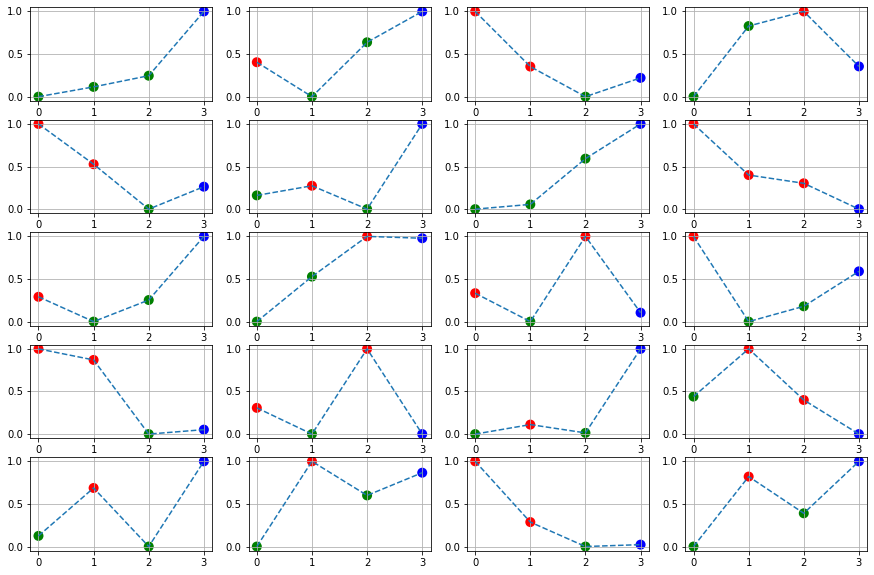

In [331]:
plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, test_x_fin.shape[0]-1)
        colors = {0:'red', 1:'green', 0.5:"blue"}
        plt.scatter(np.arange(4), test_x_fin[idx, :, 0], c=pd.Series( test_x_fin[idx, :, 1]).map(colors).values, s=100, lw=0)
        ax.plot(test_x_fin[idx,:,0], '--')
        ax.grid()

plt.show()

### Auto Encoder 1-feature 

In [42]:
model_autoenc_1 = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1.to(device)
model_autoenc_1

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

In [195]:
lr= 0.001
num_epochs= 200

train_loss, val_loss = pl.train(
    model=model_autoenc_1,
    train_x_ = train_x[:,:,0].reshape(-1, 1, LOOKBACK),
    train_y_ =  train_x[:,:,0].reshape(-1, 1, LOOKBACK),
    val_x_ = val_x[:,:,0].reshape(-1, 1, LOOKBACK),
    val_y_=  val_x[:,:,0].reshape(-1, 1, LOOKBACK),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size

MSE:  0.03068


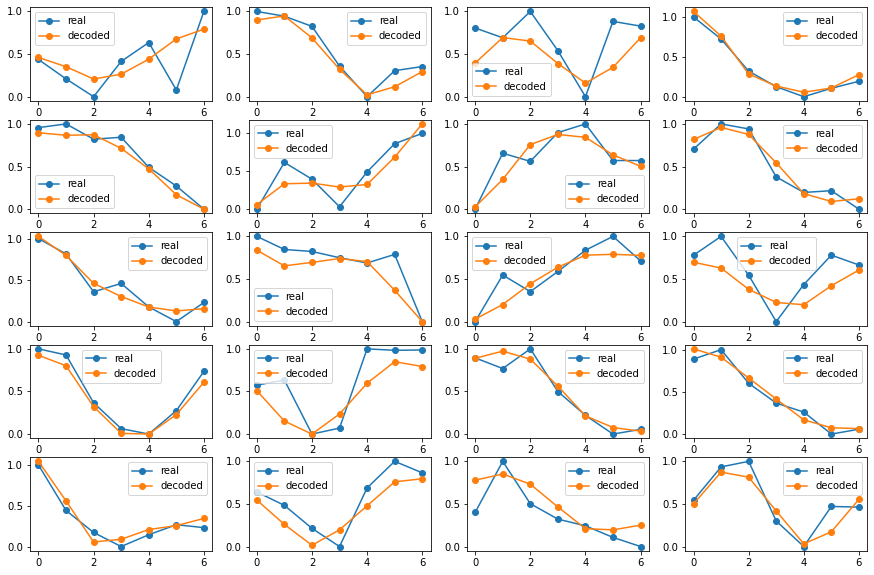

In [49]:
outputs_autoenc_1, targets, MSE = pl.evaluate(model_autoenc_1, test_x[:,:,0].reshape(-1, 1, LOOKBACK), test_x[:,:,0].reshape(-1, 1, LOOKBACK), device='cpu') 

plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, test_x.shape[0])
        ax.plot(test_x[idx,:,0], '-o', label= "real")
        ax.plot(outputs_autoenc_1[idx, 0, :], '-o', label = "decoded")
        ax.legend()
plt.show() 

In [50]:
torch.save(model_autoenc_1.cpu().state_dict(), 'Helper/model/model_autoenc_1.pth')

### Auto Encoder 17-feature 

In [336]:
model_autoenc_17 = ml.auto_encoder(
    input_size=17*2,
    nb_channel_conv=8
    )
model_autoenc_17.to(device)
model_autoenc_17

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(34, 8, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv3): Conv1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv1_t): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv2_t): ConvTranspose1d(8, 8, kernel_size=(2,), stride=(1,))
  (conv3_t): ConvTranspose1d(8, 34, kernel_size=(2,), stride=(1,))
)

 20%|██        | 10/50 [00:03<00:11,  3.40it/s]

Epoch: 10/50
MSE = [train loss mean :  0.10871902] , [val loss mean:  0.11503944, MSE (last) 11.46659%]


 40%|████      | 20/50 [00:05<00:08,  3.43it/s]

Epoch: 20/50
MSE = [train loss mean :  0.10823145] , [val loss mean:  0.11467616, MSE (last) 11.46685%]


 60%|██████    | 30/50 [00:08<00:05,  3.44it/s]

Epoch: 30/50
MSE = [train loss mean :  0.10794516] , [val loss mean:  0.11439132, MSE (last) 11.40730%]


 80%|████████  | 40/50 [00:11<00:02,  3.50it/s]

Epoch: 40/50
MSE = [train loss mean :  0.10771683] , [val loss mean:  0.11423024, MSE (last) 11.39016%]


100%|██████████| 50/50 [00:14<00:00,  3.43it/s]

Epoch: 50/50
MSE = [train loss mean :  0.10756601] , [val loss mean:  0.11408411, MSE (last) 11.37816%]


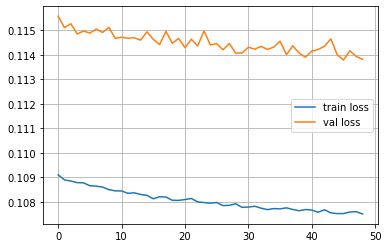

In [339]:
lr= 0.001
num_epochs= 50

train_loss, val_loss = pl.train(
    model=model_autoenc_17,
    train_x_ = np.swapaxes(train_x_fin,1,2),
    train_y_ =  np.swapaxes(train_x_fin,1,2),
    val_x_ = np.swapaxes(val_x_fin,1,2),
    val_y_=  np.swapaxes(val_x_fin,1,2),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/50)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() #4.77938%


MSE:  0.11772


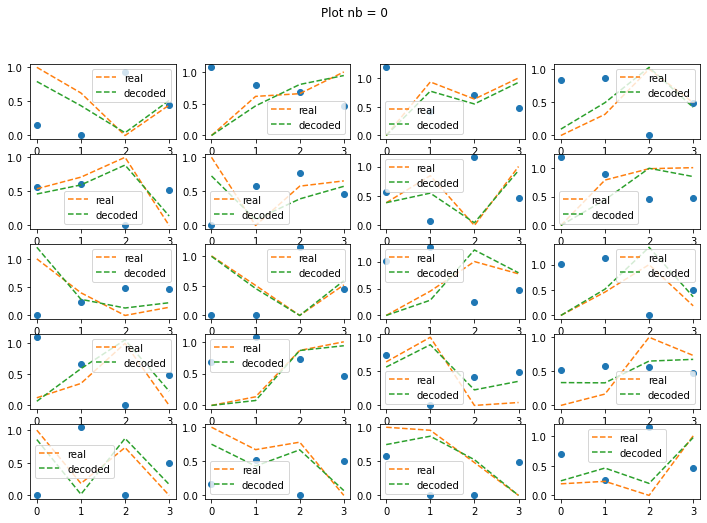

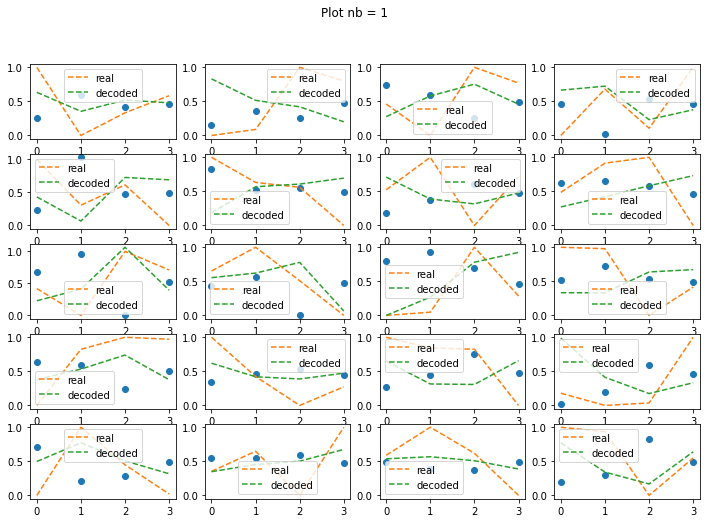

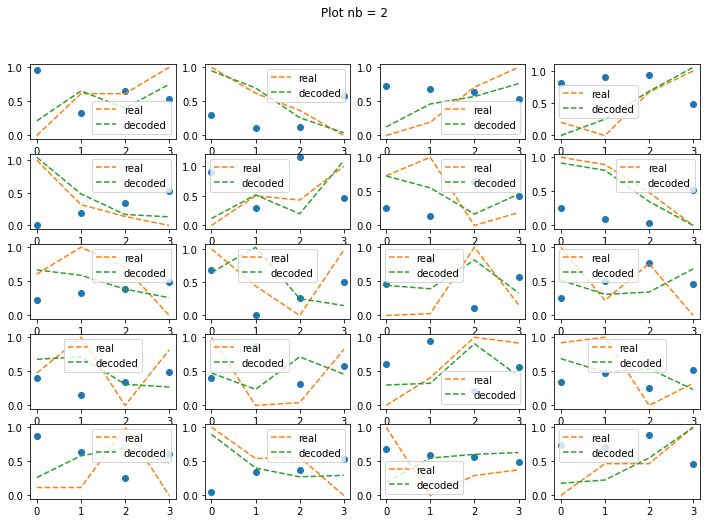

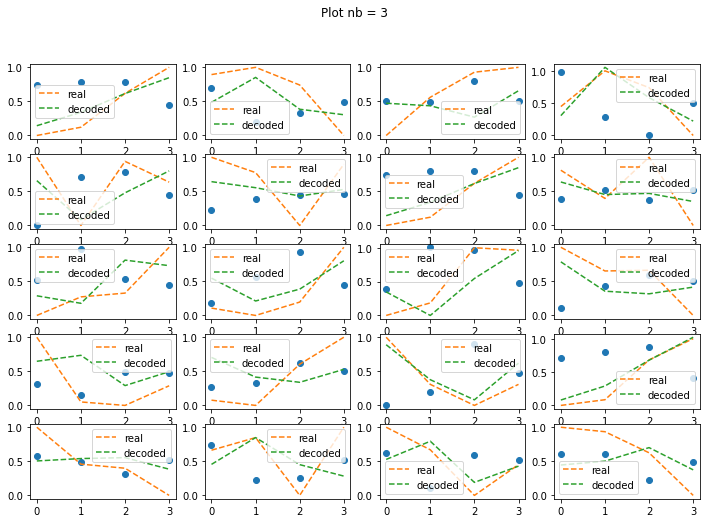

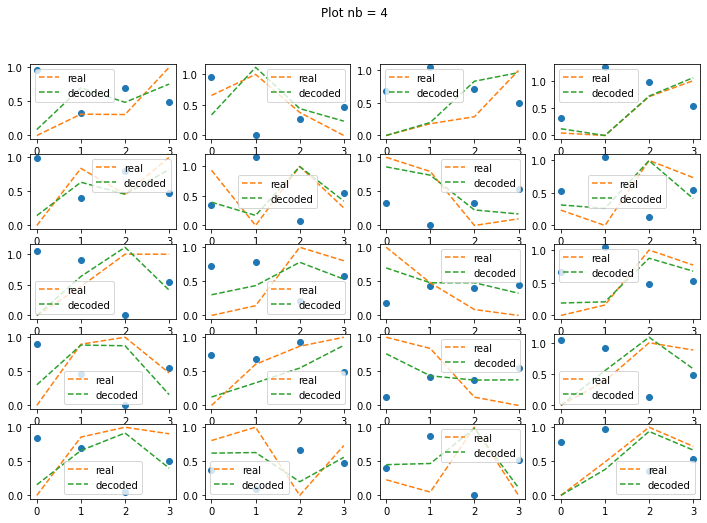

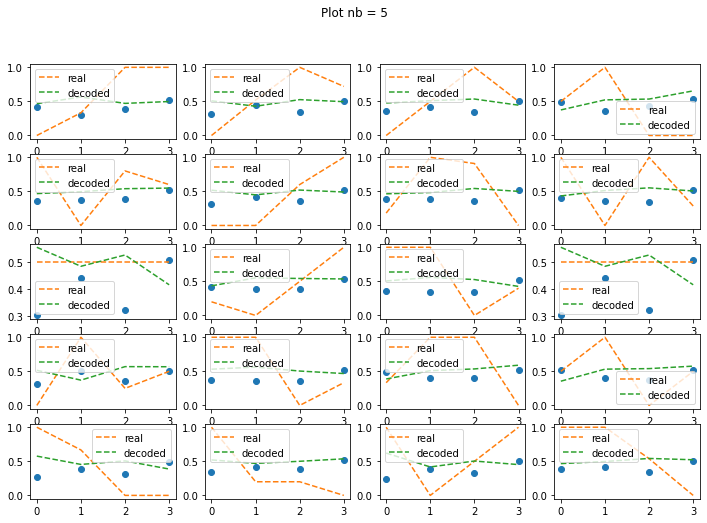

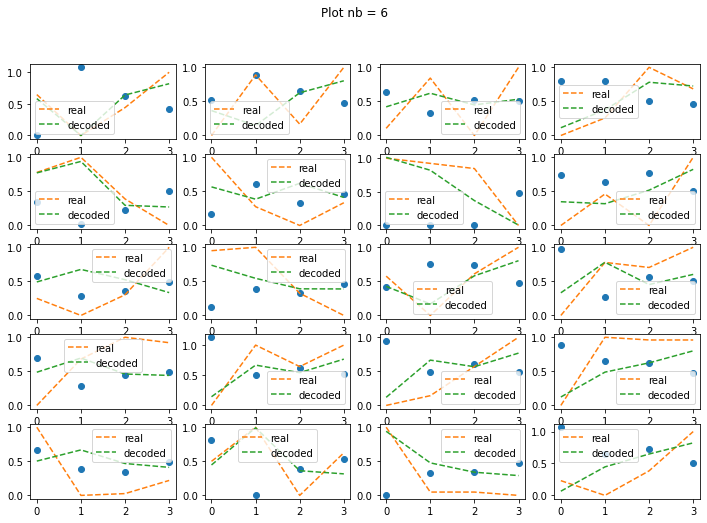

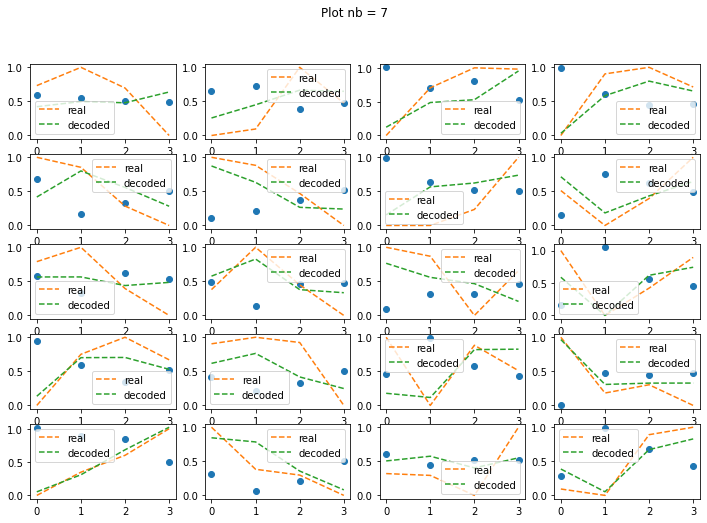

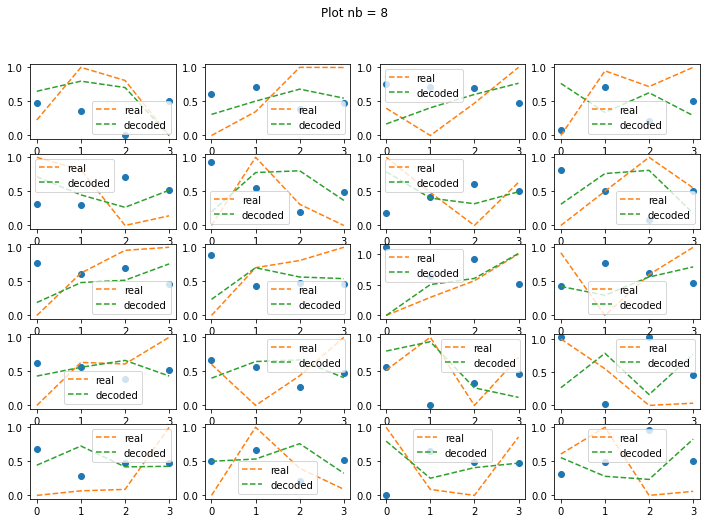

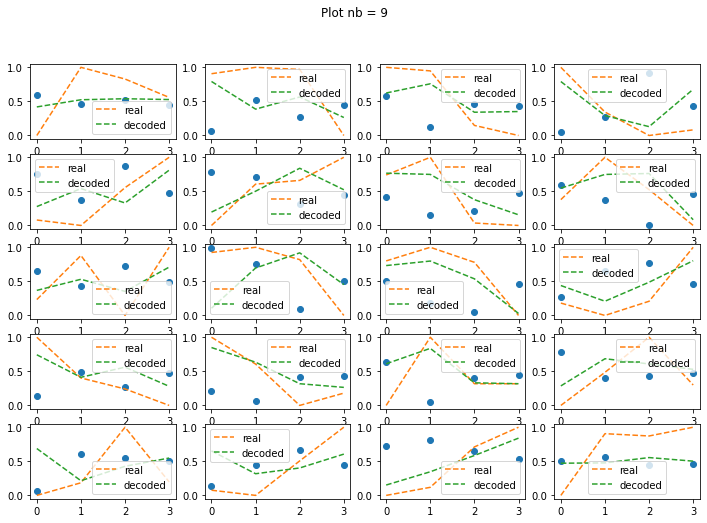

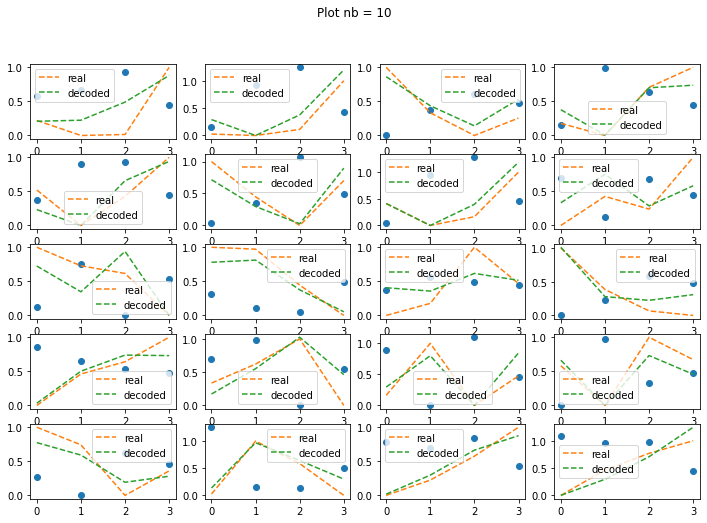

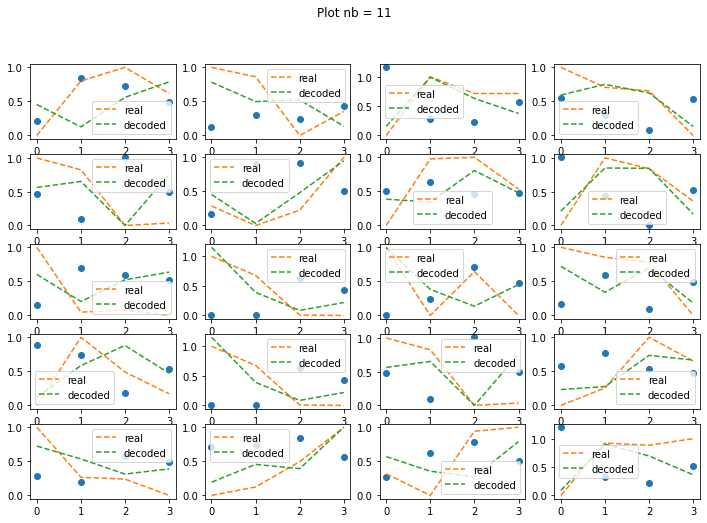

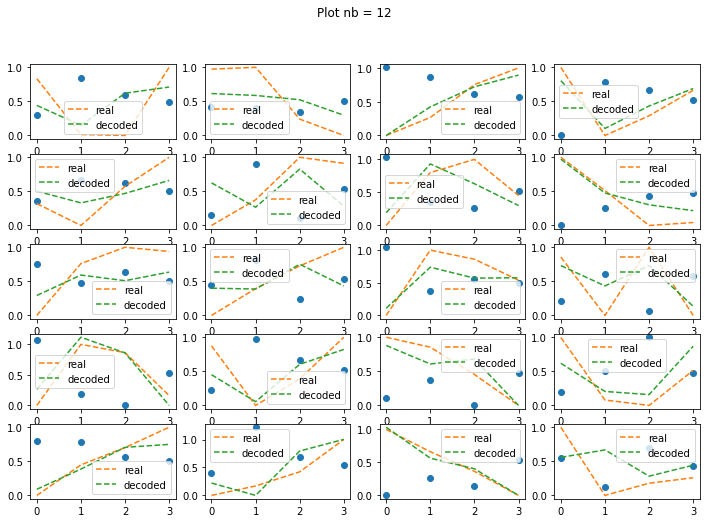

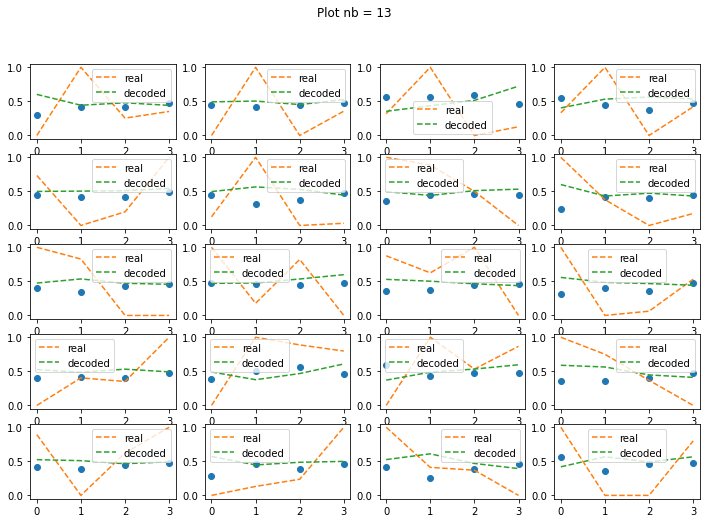

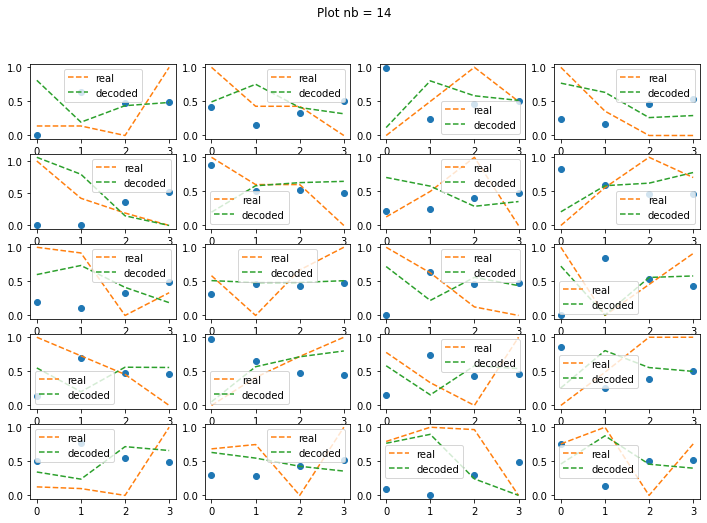

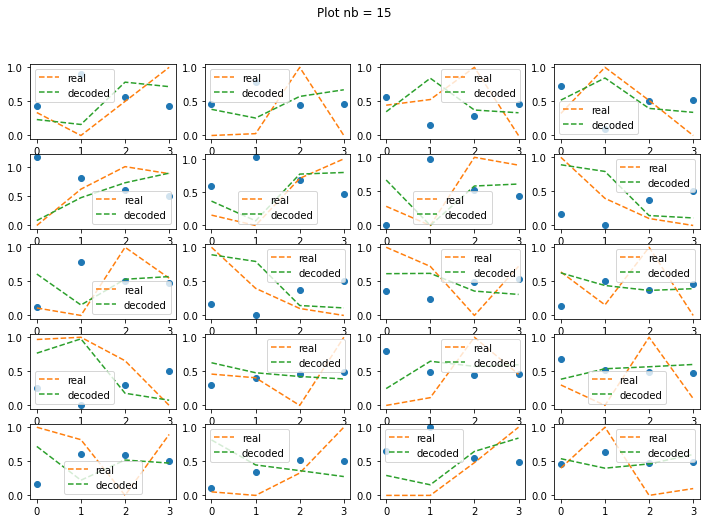

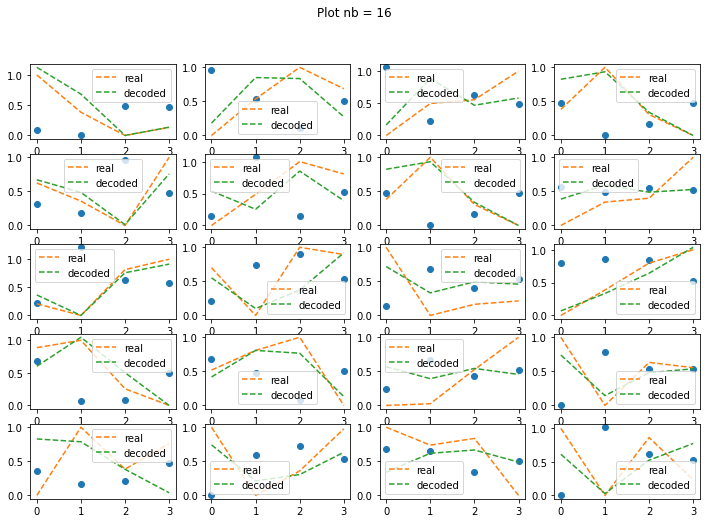

In [340]:
outputs_autoenc_17, targets, MSE = pl.evaluate(model_autoenc_17, np.swapaxes(test_x_fin,1,2), np.swapaxes(test_x_fin,1,2), device='cpu') 

for p in range(17):
    plt.figure(figsize=(12,8))
    plt.suptitle("Plot nb = " + str(p))
    plots = []
    for i in range(5):
        for j in range(4):
            ax = plt.subplot2grid((5,4), (i,j))
            idx = random.randint(0, test_x_fin.shape[0]-1)
           
            ax.plot(outputs_autoenc_17[idx,p*2+1,:], 'o')
            ax.plot(test_x_fin[idx,:,p*2], '--', label= "real")
            ax.plot(outputs_autoenc_17[idx,p*2,:], '--', label= "decoded")

            #ax.plot(test_x[idx,:,0], '--', label= "real")
            #ax.plot(outputs_autoenc_17[idx, 0, :], '-o', label = "decoded")
            ax.legend()
    plt.show() 

In [342]:
torch.save(model_autoenc_17.cpu().state_dict(), 'Helper/model/model_autoenc_17.pth')

# Auto encoder week 

### load data

In [65]:
df = pd.read_csv("Data/dataset_week_fin.csv")
df.head(2)

Date          SMI    SP500  USD_CHF  CH_infl   US_infl  Shadow  \
0  2003-09-17  5398.899902  1025.97   1.3807    0.143  0.325027    0.86   
1  2003-09-22  5257.200195  1022.82   1.3528    0.510 -0.107991    0.86   

   BondUS  BondCH  BondCH_20  BondUS_20  
0   0.958    0.18      3.700       5.71  
1   0.958    0.17      3.723       5.73

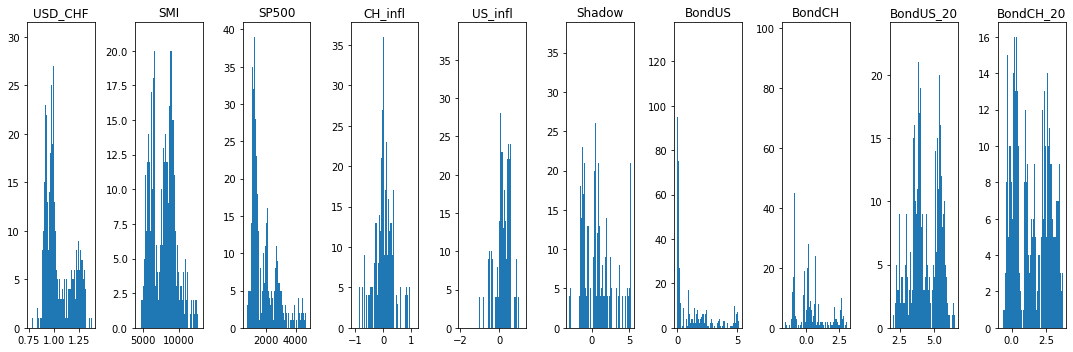

In [67]:
data = [df.USD_CHF, df.SMI, df.SP500, df.CH_infl, df.US_infl, df.Shadow, df.BondUS, df.BondCH, df.BondUS_20, df.BondCH_20]

fig = plt.figure(figsize=(15, 5))

name  = ['USD_CHF','SMI', 'SP500', 'CH_infl', 'US_infl', 'Shadow', 'BondUS', 'BondCH', 'BondUS_20', 'BondCH_20']
for i in range(len(data)):   
    plt.subplot(1,len(data),1+i)
    plt.hist(data[i], bins=150)
    plt.title(name[i])
plt.tight_layout()
plt.show()

16
2
12
Shape:             
X train     (724, 7, 10), y train     (724, 10)            
X train val (81, 7, 10) , y train val (81, 10)             
X test      (143, 7, 10) , y test      (143, 10)


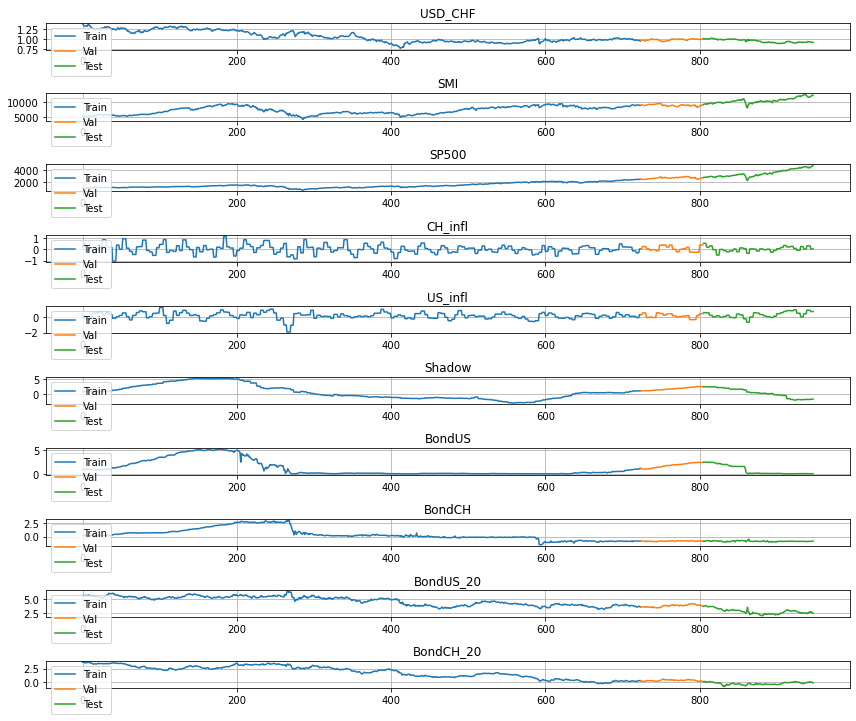

In [68]:
device = 'cpu'
LOOKBACK = 7
NORM = True
train_x, val_x, test_x, train_y, val_y, test_y, norm = pp.generate_dataset(data, lookback_=LOOKBACK, norm_=NORM, fraction_val_=0.1, fraction_test_=0.15)

l1 = len(train_x)
l2 = len(val_x) + l1
l3 = len(test_x) + l2 

fig = plt.figure(figsize=(12, 10))
nb_data = len(data)
for i in range(nb_data):
  plt.subplot(nb_data,1,i+1)
  plt.title(name[i])
  plt.plot(np.arange(l1), data[i].iloc[:l1], label='Train')
  plt.plot(np.arange(l1, l2), data[i].iloc[l1:l2], label='Val')
  plt.plot(np.arange(l2,l3), data[i].iloc[l2:l3], label='Test')
  plt.grid()
  plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [69]:
train_x[np.isnan(train_x)] = 0.5 
val_x[np.isnan(val_x)] = 0.5
test_x[np.isnan(test_x)] = 0.5
train_y[np.isnan(train_y)] = 0.5
val_y[np.isnan(val_y)] = 0.5
test_y[np.isnan(test_y)] = 0.5 

### Inspect some features

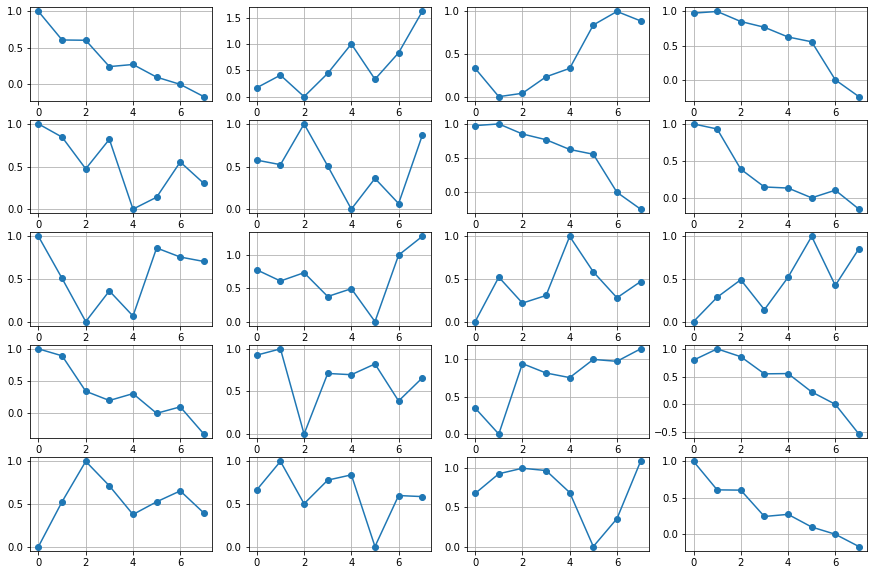

In [72]:

plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, test_x.shape[0])
        ax.plot(np.concatenate((test_x[idx,:,0], test_y[idx,0].reshape(-1,))), '-o')
        ax.grid()

plt.show()

### Auto-Encoder 1-feature 

In [117]:
model_autoenc_1_week = ml.auto_encoder(nb_channel_conv=3)
model_autoenc_1_week.to(device)
model_autoenc_1_week

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(1, 3, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(3, 3, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(3, 1, kernel_size=(3,), stride=(1,))
)

 20%|██        | 202/1000 [00:14<01:02, 12.82it/s]

Epoch: 200/1000
MSE = [train loss mean :  0.03126907] , [val loss mean:  0.03091089, MSE (last) 3.08366%]


 40%|████      | 402/1000 [00:26<00:35, 16.76it/s]

Epoch: 400/1000
MSE = [train loss mean :  0.02988121] , [val loss mean:  0.02997573, MSE (last) 2.97589%]


 60%|██████    | 602/1000 [00:39<00:32, 12.23it/s]

Epoch: 600/1000
MSE = [train loss mean :  0.02954669] , [val loss mean:  0.02982980, MSE (last) 2.96092%]


 80%|████████  | 802/1000 [00:53<00:13, 14.86it/s]

Epoch: 800/1000
MSE = [train loss mean :  0.02933297] , [val loss mean:  0.02959753, MSE (last) 2.94548%]


100%|██████████| 1000/1000 [01:05<00:00, 15.18it/s]


Epoch: 1000/1000
MSE = [train loss mean :  0.02914700] , [val loss mean:  0.02942075, MSE (last) 2.91951%]


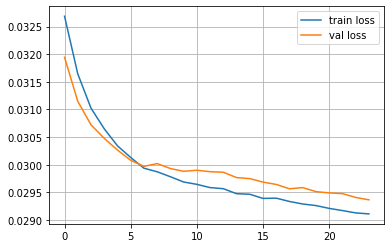

MSE:  0.04170


In [122]:
lr= 0.001
num_epochs= 1000

train_loss, val_loss = pl.train(
    model=model_autoenc_1_week,
    train_x_ = train_x[:,:,0].reshape(-1, 1, LOOKBACK),
    train_y_ =  train_x[:,:,0].reshape(-1, 1, LOOKBACK),
    val_x_ = val_x[:,:,0].reshape(-1, 1, LOOKBACK),
    val_y_=  val_x[:,:,0].reshape(-1, 1, LOOKBACK),
    batch_size_=32,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show()

outputs_autoenc_1, targets, MSE = pl.evaluate(model_autoenc_1_week, test_x[:,:,0].reshape(-1, 1, LOOKBACK), test_x[:,:,0].reshape(-1, 1, LOOKBACK), device='cpu') 


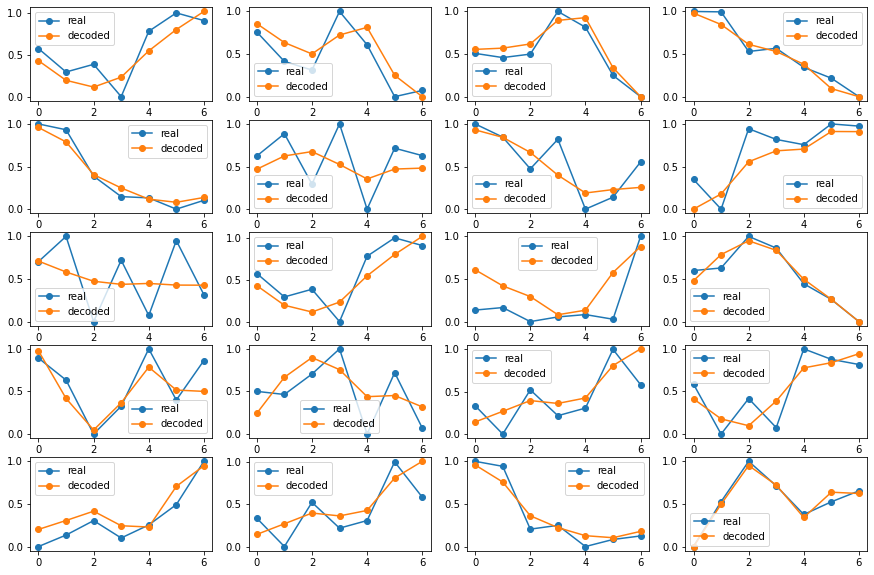

In [123]:
plt.figure(figsize=(15,10))
plots = []
for i in range(5):
    for j in range(4):
        ax = plt.subplot2grid((5,4), (i,j))
        idx = random.randint(0, test_x.shape[0]-1)
        ax.plot(test_x[idx,:,0], '-o', label= "real")
        ax.plot(outputs_autoenc_1[idx, 0, :], '-o', label = "decoded")
        ax.legend()
plt.show() 

In [124]:
torch.save(model_autoenc_1_week.cpu().state_dict(), 'Helper/model/model_autoenc_1_week.pth')

### Auto-Encoder 10-Features

In [125]:
model_autoenc_10_week = ml.auto_encoder(
    input_size=10,
    nb_channel_conv=30
    )
model_autoenc_10_week.to(device)
model_autoenc_10_week

auto_encoder(
  (relu): ReLU()
  (conv1): Conv1d(10, 30, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv1_t): ConvTranspose1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv2_t): ConvTranspose1d(30, 30, kernel_size=(3,), stride=(1,))
  (conv3_t): ConvTranspose1d(30, 10, kernel_size=(3,), stride=(1,))
)

 20%|██        | 1005/5000 [00:39<02:33, 26.05it/s]

Epoch: 1000/5000
MSE = [train loss mean :  0.04218339] , [val loss mean:  0.04633198, MSE (last) 4.57192%]


 40%|████      | 2004/5000 [01:17<01:54, 26.08it/s]

Epoch: 2000/5000
MSE = [train loss mean :  0.04152525] , [val loss mean:  0.04574083, MSE (last) 4.55948%]


 60%|██████    | 3003/5000 [01:56<01:16, 25.97it/s]

Epoch: 3000/5000
MSE = [train loss mean :  0.04113371] , [val loss mean:  0.04551908, MSE (last) 4.52501%]


 80%|████████  | 4005/5000 [02:35<00:38, 26.17it/s]

Epoch: 4000/5000
MSE = [train loss mean :  0.04008582] , [val loss mean:  0.04486601, MSE (last) 4.49491%]


100%|██████████| 5000/5000 [03:13<00:00, 25.85it/s]


Epoch: 5000/5000
MSE = [train loss mean :  0.03911717] , [val loss mean:  0.04427203, MSE (last) 4.42549%]


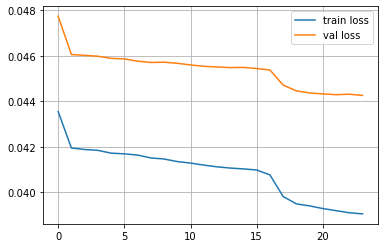

MSE:  0.05548


In [129]:
lr= 0.001
num_epochs= 5000

train_loss, val_loss = pl.train(
    model=model_autoenc_10_week,
    train_x_ = np.swapaxes(train_x,1,2),
    train_y_ =  np.swapaxes(train_x,1,2),
    val_x_ = np.swapaxes(val_x,1,2),
    val_y_=  np.swapaxes(val_x,1,2),
    batch_size_=512,
    num_epochs_=num_epochs,
    lr_=lr,
    device_=device,
    verbose = 1)
    
chunksize= int(num_epochs/25)
plt.plot(pl.smooth_loss(train_loss, chunksize = chunksize)[0:] , label="train loss")
plt.plot(pl.smooth_loss(val_loss, chunksize = chunksize)[0:] , label="val loss")
plt.legend()
plt.grid()
plt.show() #4.77938%


outputs_autoenc_10, targets, MSE = pl.evaluate(model_autoenc_10_week, np.swapaxes(test_x,1,2), np.swapaxes(test_x,1,2), device='cpu') 



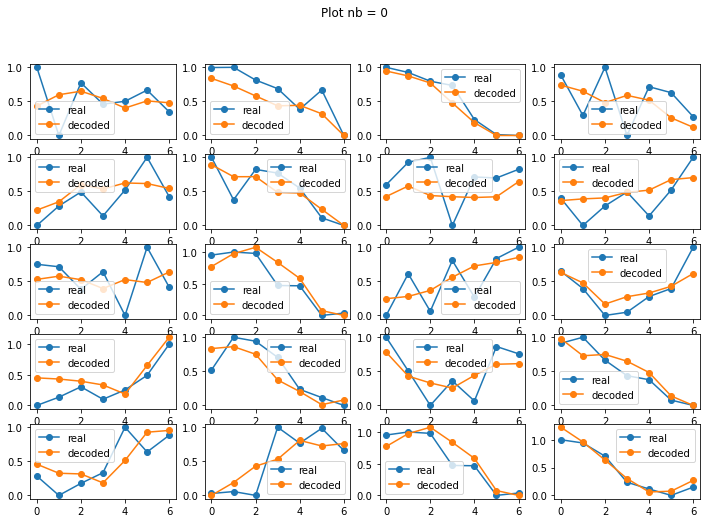

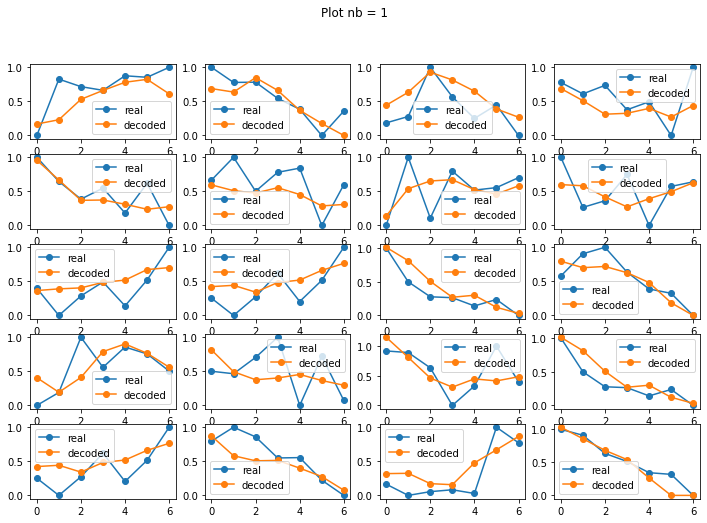

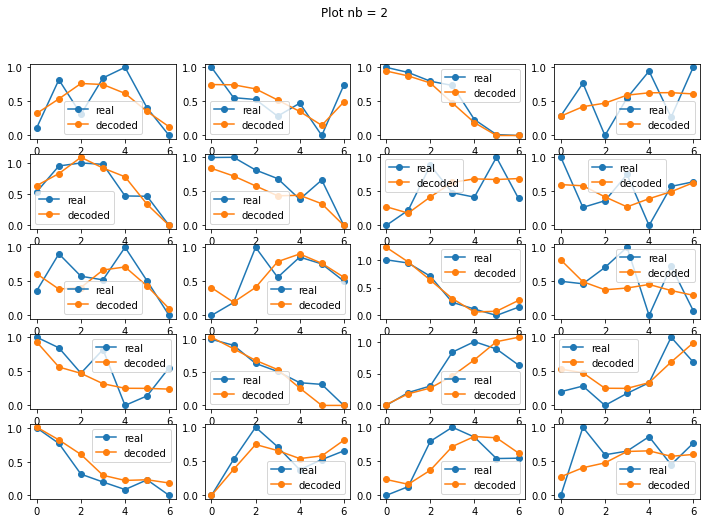

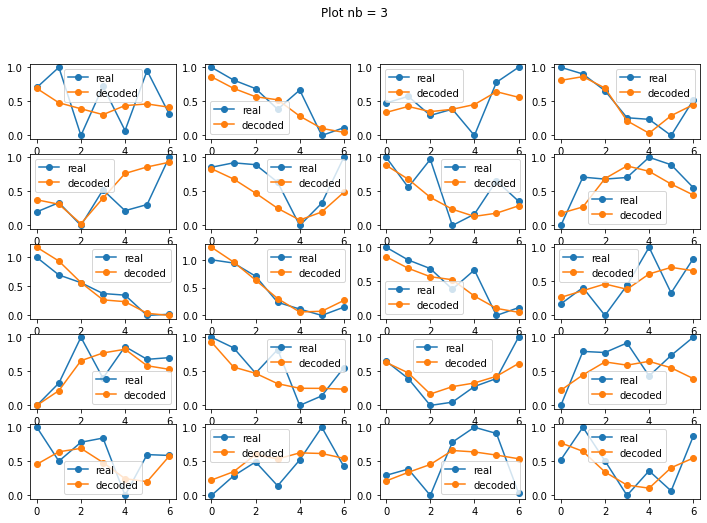

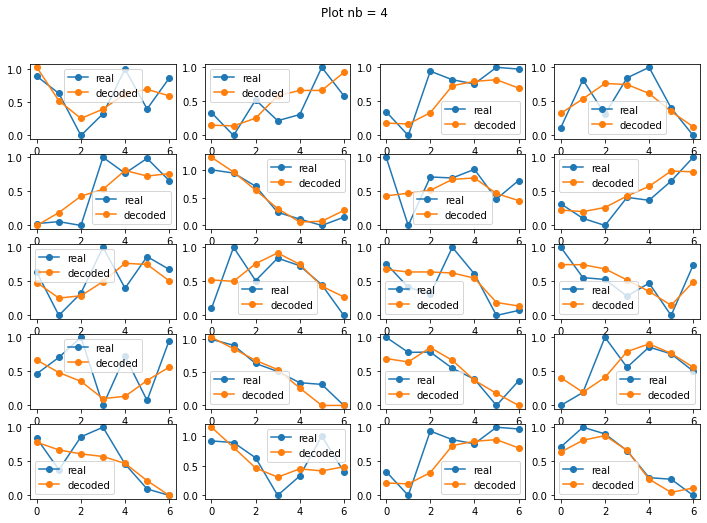

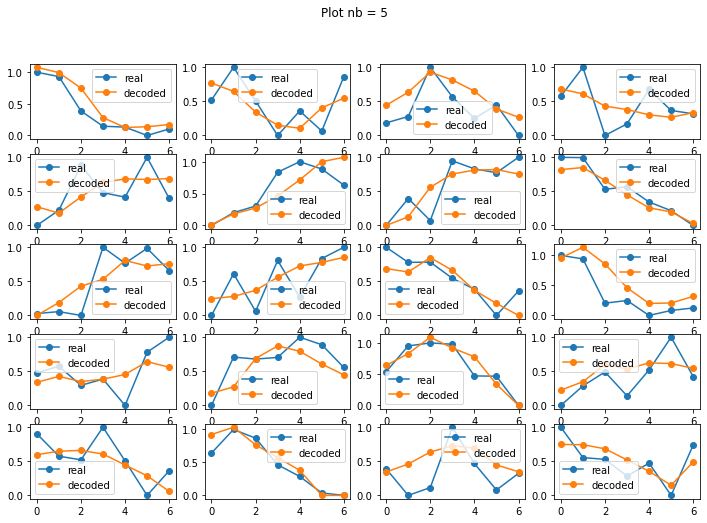

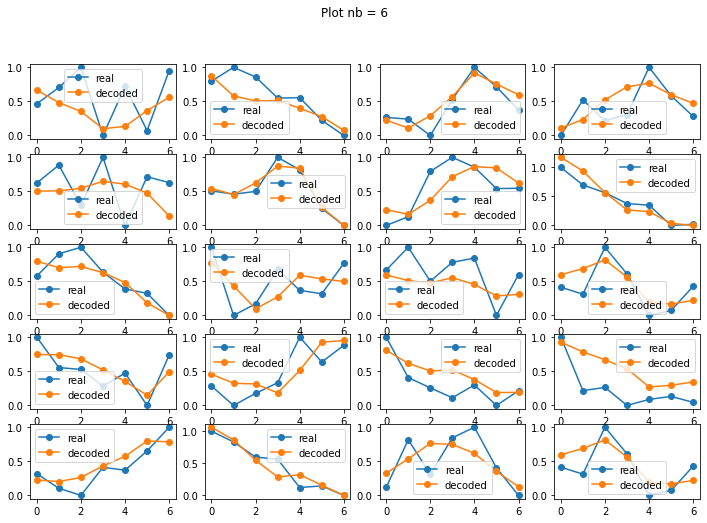

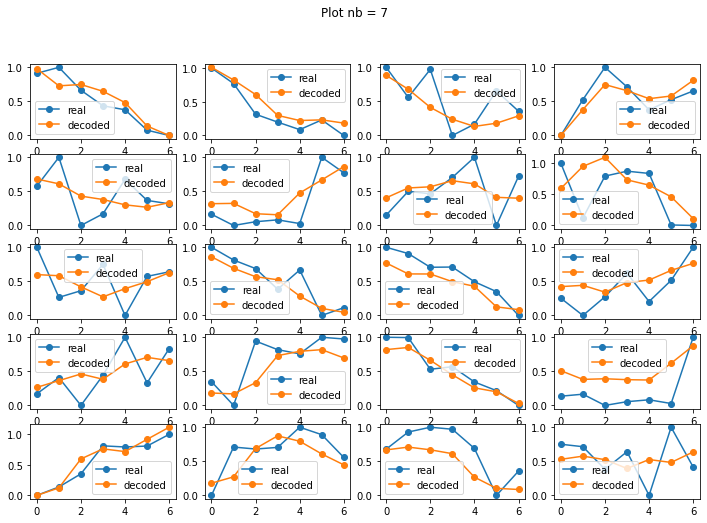

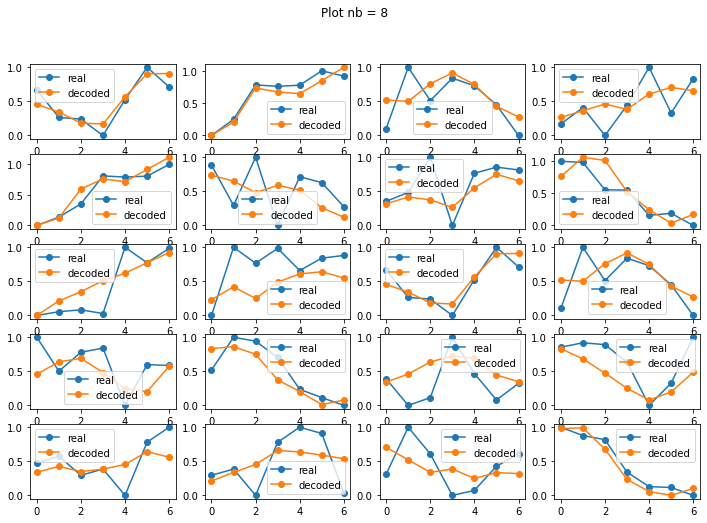

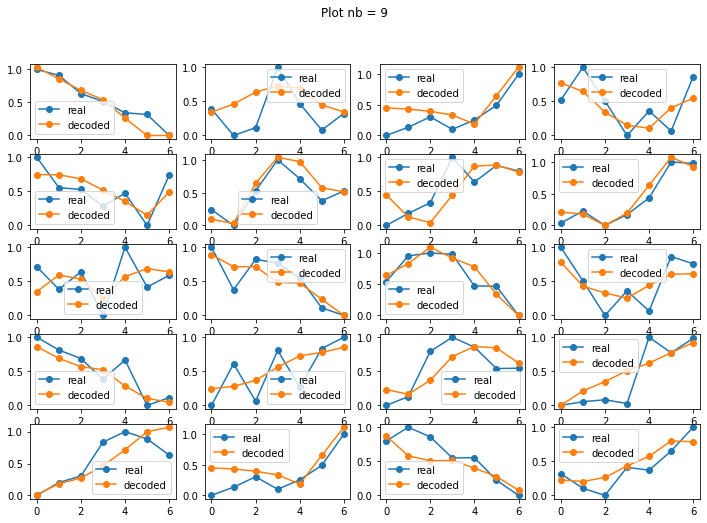

In [131]:
for p in range(10):
    plt.figure(figsize=(12,8))
    plt.suptitle("Plot nb = " + str(p))
    plots = []
    for i in range(5):
        for j in range(4):
            ax = plt.subplot2grid((5,4), (i,j))
            idx = random.randint(0, test_x.shape[0]-1)
            ax.plot(test_x[idx,:,0], '-o', label= "real")
            ax.plot(outputs_autoenc_10[idx, 0, :], '-o', label = "decoded")
            ax.legend()
    plt.show() 


In [133]:
torch.save(model_autoenc_10_week.cpu().state_dict(), 'Helper/model/model_autoenc_10_week.pth')